In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import seaborn as sns

# processing / validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# keras/tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

# models
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.ensemble import VotingRegressor

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# constant seed for reproducibility
SEED = 111 
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# cpu workers
WORKERS = 6 

In [2]:
tickers = ["ASIANPAINT.NS","ADANIPORTS.NS","AXISBANK.NS","BAJAJ-AUTO.NS",
           "BAJFINANCE.NS","BAJAJFINSV.NS","BPCL.NS","BHARTIARTL.NS",
           "INFRATEL.NS","CIPLA.NS","COALINDIA.NS","DRREDDY.NS","EICHERMOT.NS",
           "GAIL.NS","GRASIM.NS","HCLTECH.NS","HDFCBANK.NS","HEROMOTOCO.NS",
           "HINDALCO.NS","HINDPETRO.NS","HINDUNILVR.NS","HDFC.NS","ITC.NS",
           "ICICIBANK.NS","IBULHSGFIN.NS","IOC.NS","INDUSINDBK.NS","INFY.NS",

           
           ]

df = pd.DataFrame() 
attempt = 0
drop = []
while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop] 
    for i in range(len(tickers)):
        try:
            temp = web.get_data_yahoo(tickers[i],datetime.date.today() - datetime.timedelta(365*1), # reduce delta
                                      datetime.date.today())
            
            temp.dropna(inplace = True)
            df[tickers[i]] = temp["Adj Close"]
            drop.append(tickers[i])       
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1
    

df.rename( {"ASIANPAINT.NS":"target"},axis=1, inplace=True)
df.dropna(inplace=True, axis=1, how='any')

In [19]:
X = df.drop("target", axis=1).values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=SEED)
print(f"X_train shape:{X_train.shape}")

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dnnReg = Sequential()

dnnReg.add(Dense(100, activation="relu"))
dnnReg.add(Dense(100, activation="relu"))
dnnReg.add(Dense(100, activation="relu"))
dnnReg.add(Dense(1))

dnnReg.compile(optimizer="adam", loss="mse")

X_train shape:(145, 26)


Train on 145 samples, validate on 97 samples
Epoch 1/10
145/145 [==============================] - 1s 9ms/sample - loss: 2514136.2466 - val_loss: 2426029.2332
Epoch 2/10
145/145 [==============================] - 0s 933us/sample - loss: 2511416.7000 - val_loss: 2423018.7191
Epoch 3/10
145/145 [==============================] - 0s 915us/sample - loss: 2507835.4276 - val_loss: 2418520.3041
Epoch 4/10
145/145 [==============================] - 0s 892us/sample - loss: 2502311.1517 - val_loss: 2411281.7113
Epoch 5/10
145/145 [==============================] - 0s 948us/sample - loss: 2493297.4345 - val_loss: 2399315.0296
Epoch 6/10
145/145 [==============================] - 0s 922us/sample - loss: 2478413.5552 - val_loss: 2379833.5928
Epoch 7/10
145/145 [==============================] - 0s 863us/sample - loss: 2454342.1707 - val_loss: 2348771.3144
Epoch 8/10
145/145 [==============================] - 0s 908us/sample - loss: 2416778.1879 - val_loss: 2300734.1830
Epoch 9/10
145/145 [=========

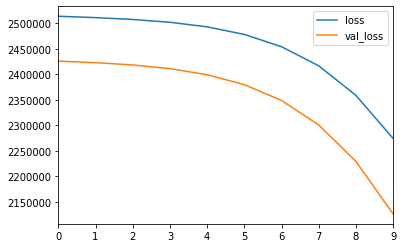

In [20]:
dnnReg.fit(x=X_train_scaled, y=y_train, epochs=10,validation_data=(X_test_scaled,y_test),use_multiprocessing=True, workers=WORKERS)
pd.DataFrame(dnnReg.history.history).plot()

In [22]:
dnnPreds = dnnReg.predict(X_test)
print(mean_squared_error(y_test, dnnPreds))
print(r2_score(y_test, dnnPreds))

196101323578.8735
-7024720.072456295


In [23]:
svmReg = svm.SVR(kernel='linear').fit(X_train, y_train)
svmPreds = svmReg.predict(X_test)
print(mean_squared_error(y_test, svmPreds))
print(r2_score(y_test, svmPreds))

15261.011969159503
0.4533216277673717


In [24]:
gboostReg = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1,  loss='ls', random_state=SEED).fit(X_train, y_train)
gboostPredds = gboostReg.predict(X_test)
print(mean_squared_error(y_test, gboostPredds))
print(r2_score(y_test, gboostPredds))

1279.0458195169401
0.9541821546279163


In [26]:
dtReg = tree.DecisionTreeRegressor(random_state=SEED).fit(X_train, y_train)
dtPredds = dtReg.predict(X_test)
print(mean_squared_error(y_test, dtPredds))
print(r2_score(y_test, dtPredds))

1612.226897899484
0.9422469769374088


In [28]:
ensReg = VotingRegressor(estimators=
                         [
                             ('svmReg', svmReg),
                             ('gboost', gboostReg),
                             ('dtReg', dtReg)
                         ]
                        ).fit(X_train, y_train)
print(mean_squared_error(y_test, ensReg.predict(X_test)))
print(r2_score(y_test, ensReg.predict(X_test)))

2699.3574747880784
0.9033038992844459
